<a href="https://colab.research.google.com/github/bs3537/dengueAI/blob/master/V15_SJ_RF_Classification_environmental_and_time_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
#used f1 as metric in hyperparameter tuning and used only top 5 features with positive weights

##LIST OF FEATURES:
You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)

###City and date indicators
1. city – City abbreviations: sj for San Juan and iq for Iquitos
2. week_start_date – Date given in yyyy-mm-dd format
###NOAA's GHCN daily climate data weather station measurements
1. station_max_temp_c – Maximum temperature
2. station_min_temp_c – Minimum temperature
3. station_avg_temp_c – Average temperature
4. station_precip_mm – Total precipitation
5. station_diur_temp_rng_c – Diurnal temperature range

###PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

6. precipitation_amt_mm – Total precipitation

###NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

7. reanalysis_sat_precip_amt_mm – Total precipitation
8. reanalysis_dew_point_temp_k – Mean dew point temperature
9. reanalysis_air_temp_k – Mean air temperature
10. reanalysis_relative_humidity_percent – Mean relative humidity
11. reanalysis_specific_humidity_g_per_kg – Mean specific humidity
12. reanalysis_precip_amt_kg_per_m2 – Total precipitation
13. reanalysis_max_air_temp_k – Maximum air temperature
14. reanalysis_min_air_temp_k – Minimum air temperature
15. reanalysis_avg_temp_k – Average air temperature
16. reanalysis_tdtr_k – Diurnal temperature range

###Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
17. ndvi_se – Pixel southeast of city centroid
18. ndvi_sw – Pixel southwest of city centroid
19. ndvi_ne – Pixel northeast of city centroid
20. ndvi_nw – Pixel northwest of city centroid

####TARGET VARIABLE = total_cases label for each (city, year, weekofyear)

In [0]:
import sys

In [0]:
#Load train features and labels datasets
train_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_train.csv')

In [0]:
train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [0]:
train_features.shape

(1456, 24)

In [0]:
train_labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_labels_train.csv')

In [0]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [0]:
train_labels.shape

(1456, 4)

In [0]:
#Merge train features and labels datasets

In [0]:
train = pd.merge(train_features, train_labels)

In [0]:
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [0]:
train.shape
#city, year and week of year columns are duplicate in train_features and train_labels datasets so the total_cases column is added to the features dataset

(1456, 25)

In [0]:
train.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [0]:
#Data rows for San Juan 
train.city.value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [0]:
#San Juan has 936 rows which we can isolate and analyze separately

In [0]:
train = train[train['city'].str.match('sj')]

In [0]:
train.head(5)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [0]:
train.shape

(936, 25)

In [0]:
#Thus, we have isolated the train dataset with only city data for San Juan

In [0]:
train['total_cases'].describe()

count    936.000000
mean      34.180556
std       51.381372
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64

In [0]:
dengue_cases = train['total_cases']
dengue_cases

0      4
1      5
2      4
3      3
4      6
      ..
931    4
932    3
933    1
934    3
935    5
Name: total_cases, Length: 936, dtype: int64

In [0]:
np.percentile(dengue_cases, 95)

112.0

In [0]:
train['dengue_outbreak']  = train['total_cases'] > 112

In [0]:
train.shape

(936, 26)

In [0]:
#Do train, val split
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['dengue_outbreak'], 
                              random_state=42, )
train.shape, val.shape

((748, 26), (188, 26))

In [0]:
#Baseline statistics for the target variable total_cases in train dataset

In [0]:
train['dengue_outbreak'].value_counts(normalize=True)

False    0.951872
True     0.048128
Name: dengue_outbreak, dtype: float64

In [0]:
#we need to convert week_start_date to numeric form uisng pd.to_dateime function
#wrangle function 

def wrangle(X):
  X = X.copy()
       
    # Convert week_start_date to numeric form
  X['week_start_date'] = pd.to_datetime(X['week_start_date'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['week_start_date'].dt.year
  X['month_recorded'] = X['week_start_date'].dt.month
  #X['day_recorded'] = X['week_start_date'].dt.day
  X = X.drop(columns='week_start_date')
  X = X.drop(columns='year')
  X = X.drop(columns='station_precip_mm')

#I engineered few features which represent standing water, high risk feature for mosquitos

  #1. X['standing water feature 1'] = X['station_precip_mm'] / X['station_max_temp_c']

  #Standing water features
  X['total satellite vegetation index of city'] = X['ndvi_se'] + X['ndvi_sw'] + X['ndvi_ne'] + X['ndvi_nw']

  #Standing water features

  #Standing water feature 1 = 'NOAA GCN precipitation amount in kg per m2 reanalyzed' * (total vegetation, sum of all 4 parts of the city)
  X['standing water feature 1'] = X['reanalysis_precip_amt_kg_per_m2'] * X['total satellite vegetation index of city'] 
  #Standing water feature 2: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'}
  X['standing water feature 2'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent']   
  #Standing water feature 3: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'} * (total vegetation)
  X['standing water feature 3'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent'] * X['total satellite vegetation index of city']  
  #Standing water feature 4: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} / 'NOAA GCN max air temp reanalyzed'
  X['standing water feature 4'] = X['reanalysis_precip_amt_kg_per_m2'] / X['reanalysis_max_air_temp_k']
  #Standing water feature 5: ['NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'} * (total vegetation)]/['NOAA GCN max air temp reanalyzed']
  X['standing water feature 5'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent'] * X['total satellite vegetation index of city'] / X['reanalysis_max_air_temp_k']

  
  #Rename columns
  X.rename(columns= {'reanalysis_air_temp_k':'Mean air temperature in K'}, inplace=True)
  X.rename(columns= {'reanalysis_min_air_temp_k':'Minimum air temperature in K'}, inplace=True)
  X.rename(columns= {'weekofyear':'Week of Year'}, inplace=True)
  X.rename(columns= {'station_diur_temp_rng_c':'Diurnal temperature range in C'}, inplace=True)
  X.rename(columns= {'reanalysis_precip_amt_kg_per_m2':'Total precipitation kg/m2'}, inplace=True)
  X.rename(columns= {'reanalysis_tdtr_k':'Diurnal temperature range in K'}, inplace=True)
  X.rename(columns= {'reanalysis_max_air_temp_k':'Maximum air temperature in K'}, inplace=True)
  X.rename(columns= {'year_recorded':'Year recorded'}, inplace=True)
  X.rename(columns= {'reanalysis_relative_humidity_percent':'Mean relative humidity'}, inplace=True)
  X.rename(columns= {'month_recorded':'Month recorded'}, inplace=True)
  X.rename(columns= {'reanalysis_dew_point_temp_k':'Mean dew point temp in K'}, inplace=True)
  X.rename(columns= {'precipitation_amt_mm':'Total precipitation in mm'}, inplace=True)
  X.rename(columns= {'station_min_temp_c':'Minimum temp in C'}, inplace=True)
  X.rename(columns= {'ndvi_se':'Southeast vegetation index'}, inplace=True)
  X.rename(columns= {'ndvi_ne':'Northeast vegetation index'}, inplace=True)
  X.rename(columns= {'ndvi_nw':'Northwest vegetation index'}, inplace=True)
  X.rename(columns= {'ndvi_sw':'Southwest vegetation index'}, inplace=True)
  X.rename(columns= {'reanalysis_avg_temp_k':'Average air temperature in K'}, inplace=True)
  X.rename(columns= {'reanalysis_sat_precip_amt_mm':'Total precipitation in mm (2)'}, inplace=True)
  X.rename(columns= {'reanalysis_specific_humidity_g_per_kg':'Mean specific humidity'}, inplace=True)
  X.rename(columns= {'station_avg_temp_c':'Average temp in C'}, inplace=True)
  X.rename(columns= {'station_max_temp_c':'Maximum temp in C'}, inplace=True)
  X.rename(columns= {'total_cases':'Total dengue cases in the week'}, inplace=True) 

  #Drop columns
  X = X.drop(columns='Total precipitation in mm (2)')
  X = X.drop(columns='Average temp in C')
  X = X.drop(columns='Maximum temp in C')
  X = X.drop(columns='Minimum temp in C')
  X = X.drop(columns='Diurnal temperature range in C')
  X = X.drop(columns='Average air temperature in K')
  X = X.drop(columns='city')
  X = X.drop(columns='Total dengue cases in the week')
  X = X.drop(columns='Northeast vegetation index')
  X = X.drop(columns='Mean air temperature in K')
  X = X.drop(columns='standing water feature 2')
  X = X.drop(columns='Maximum air temperature in K')
  X = X.drop(columns='Mean specific humidity')
  X = X.drop(columns='Total precipitation kg/m2')
  X = X.drop(columns='Minimum air temperature in K')
  X = X.drop(columns='standing water feature 4')
  X = X.drop(columns='Northwest vegetation index')
  X = X.drop(columns='Mean dew point temp in K')
  X = X.drop(columns='Diurnal temperature range in K')
  X = X.drop(columns='standing water feature 3')
  X = X.drop(columns='standing water feature 1')
  X = X.drop(columns='total satellite vegetation index of city')
  X = X.drop(columns='standing water feature 5')
  X = X.drop(columns='Mean relative humidity')
  X = X.drop(columns='Total precipitation in mm')
  X = X.drop(columns='Southeast vegetation index')


    # return the wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)


In [0]:
train.head().T

,437,519,704,17,396
Week of Year,39,16,46,35,50
Southwest vegetation index,0.206686,0.0765571,0.0748857,0.284314,0.235471
dengue_outbreak,False,False,False,False,False
Year recorded,1998,2000,2003,1990,1997
Month recorded,9,4,11,8,12


In [0]:
train.dtypes

Week of Year                    int64
Southwest vegetation index    float64
dengue_outbreak                  bool
Year recorded                   int64
Month recorded                  int64
dtype: object

In [0]:
#Fitting RForestClassifier model

In [0]:
#Define target and features

In [0]:
# The status_group column is the target
target = 'dengue_outbreak'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()


# Combine the lists 
features = numeric_features 



In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]


In [0]:
pip install category_encoders

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, preprocessing
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [0]:
#Pipeline
pipeline = make_pipeline( 
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'),  
    RandomForestClassifier(n_estimators=100, n_jobs=-1, max_features='auto', random_state=50),
)

In [0]:
#define parameter distributions for RandomizedSearchCV
param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],  
    'randomforestclassifier__n_estimators': randint(50, 1000), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, 25, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}

In [0]:
%time
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='f1', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   29.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fil

In [0]:
print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': 0.6515508085841569, 'randomforestclassifier__n_estimators': 854, 'simpleimputer__strategy': 'median'}
Accuracy 0.5429463088359464


In [0]:
print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)
print('Best estimator', search.best_estimator_)

Best hyperparameters {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': 0.6515508085841569, 'randomforestclassifier__n_estimators': 854, 'simpleimputer__strategy': 'median'}
Accuracy 0.5429463088359464
Best estimator Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=25,
                                        max_features=0.65

In [0]:
#make predictions on test set
pipeline2 = search.best_estimator_

In [0]:
# Predict on Val Data
y_pred = pipeline2.predict(X_val)

In [0]:
#Validation accuracy
pipeline2.score(X_val, y_val)

0.9893617021276596

In [0]:
# Predicted probabilities for positive class
y_pred_proba = pipeline2.predict_proba(X_val)[:, 1] # Probability for positive class

In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9993792675356921

In [0]:
# Compute the confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[179,   0],
       [  2,   7]])

In [0]:
pip install scikit-plot

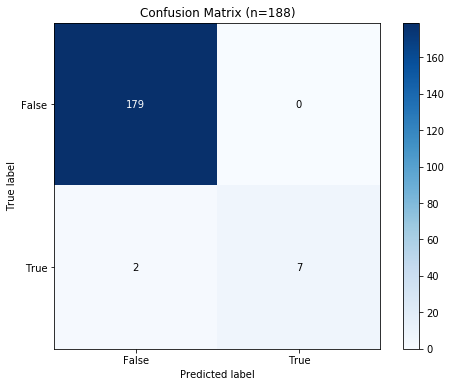

In [0]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred, 
                                    figsize=(8,6),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=False);

In [0]:
#F SCORE, PRECISION AND RECAL, F SCORE BETTER METRIC THAN ROC-AUC OR ACCURACY FOR IMBLANCED DATA
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99       179
        True       1.00      0.78      0.88         9

    accuracy                           0.99       188
   macro avg       0.99      0.89      0.93       188
weighted avg       0.99      0.99      0.99       188



In [0]:
pip install eli5

     |████████████████████████████████| 112kB 3.4MB/s 


In [0]:
#PERMUTATION IMPORTANCE PLOT
import eli5
from eli5.sklearn import PermutationImportance
#Eli5 needs ordinal encoding
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median') 
)
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = RandomForestClassifier(n_estimators=854, random_state=42, n_jobs=-1, max_depth=25, max_features='auto')
model.fit(X_train_transformed, y_train)

permuter = PermutationImportance(
    model,
    scoring= 'accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)
permuter.feature_importances_
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Using TensorFlow backend.


Weight,Feature
0.0564 ± 0.0327,Year recorded
0.0351 ± 0.0128,Month recorded
0.0298 ± 0.0085,Week of Year
0.0181 ± 0.0197,Southwest vegetation index
